In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torchvision.datasets as datasets
from torchvision.models import get_model
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import bagnets # bagnetsv2 as bagnets 
import pretrain_imagenet as pt
import utils

device = 'cuda:0'
utils.set_seed(utils.SEED)

### Load dataset and model

In [2]:
# Experiment arguments
backbone = 'bagnet33'
weights = 'DEFAULT'
n_classes = 10000
dataset = 'imagenet'
img_size = (224, 224)
batch_size = 128
num_workers = 4

In [ ]:
# Load hold-out test set
transform = utils.get_augmentations(img_size, normalization=utils.IMAGENET_NORMALIZATION, imagenet=True)['test']
transform_orig = utils.get_augmentations(img_size, normalization=None, imagenet=True)['test'] # For the overlay of the heatmaps

if dataset == 'imagenet':
    dataset_test = datasets.ImageNet(utils.IMAGENET_DIR, split='val', transform=transform)
    dataset_orig = datasets.ImageNet(utils.IMAGENET_DIR, split='val', transform=transform_orig)
    n_classes = 1000
else:
    dataset_test = datasets.Imagenette('datasets', split='val', transform=transform, size='320px')
    dataset_orig = datasets.Imagenette('datasets', split='val', transform=transform_orig, size='320px')
    n_classes = 10

dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True, drop_last=True)
img_batch = dataset_test[0][0].unsqueeze(0).to(device) # Test image
img_label = dataset_test[0][1]

In [ ]:
model = bagnets.get_bagnet(backbone, weights=weights, num_classes=1000)
# checkpoint = torch.load(checkpoint_file, map_location=torch.device('cpu'))
# state_dict = checkpoint['state_dict'] if isinstance(checkpoint, dict) else checkpoint
# model.load_state_dict(state_dict)
model.to(device)
model.eval();

### 1. Bagnet prediction difference with TF32 vs F32

In [6]:
torch.backends.cudnn.allow_tf32 = True
prediction_tf32 = model(img_batch)[0, img_label]
print(f'Prediction with tf32 = {prediction_tf32.item():.4f}')

torch.backends.cudnn.allow_tf32 = False
prediction_fp32 = model(img_batch)[0, img_label]
print(f'Prediction with fp32 = {prediction_fp32.item():.4f}')

absolute_diff = (prediction_fp32 - prediction_tf32).abs()
print(f'Absolute difference = {absolute_diff.item():.3e}')

relative_diff = absolute_diff * 100 / prediction_tf32
print(f'Relative difference = {relative_diff.item():.2f}%')

Prediction with tf32 = 17.7340
Prediction with fp32 = 16.3335
Absolute difference = 1.400e+00
Relative difference = 7.90%


### 2. BagNet weight distribution

In [7]:
for name, parameters in model.named_parameters():
    if 'conv' in name:
        max_weight = parameters.flatten().abs().max()
        print(f'Maximum absolute value of the weights from layer {name} = {max_weight.item():.3e}')

Maximum absolute value of the weights from layer conv1.weight = 8.554e-01
Maximum absolute value of the weights from layer conv2.weight = 6.369e-01
Maximum absolute value of the weights from layer layer1.0.conv1.weight = 7.247e+00
Maximum absolute value of the weights from layer layer1.0.conv2.weight = 4.254e-01
Maximum absolute value of the weights from layer layer1.0.conv3.weight = 8.943e+00
Maximum absolute value of the weights from layer layer1.1.conv1.weight = 8.108e-08
Maximum absolute value of the weights from layer layer1.1.conv2.weight = 1.165e-07
Maximum absolute value of the weights from layer layer1.1.conv3.weight = 1.049e-07
Maximum absolute value of the weights from layer layer1.2.conv1.weight = 8.242e-08
Maximum absolute value of the weights from layer layer1.2.conv2.weight = 9.762e-08
Maximum absolute value of the weights from layer layer1.2.conv3.weight = 9.184e-08
Maximum absolute value of the weights from layer layer2.0.conv1.weight = 4.534e-01
Maximum absolute value

Text(0.5, 0, 'Weight Values')

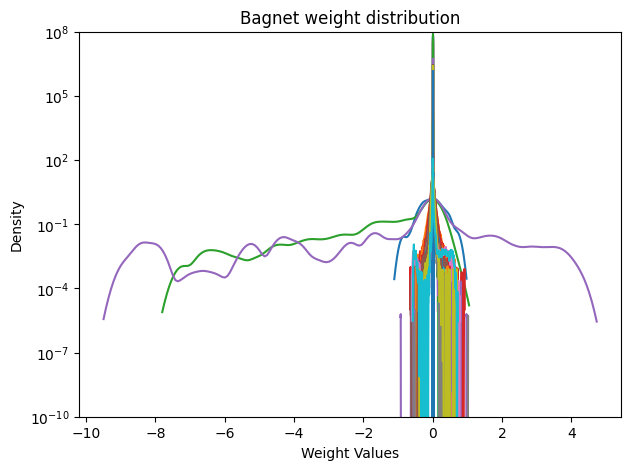

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
for name, parameters in model.named_parameters():
    if 'conv' in name:
        params = parameters.detach().cpu().numpy().flatten()
        sns.kdeplot(x=params, ax=ax)

# ax.set_xlim([-2, 2])
ax.set_ylim([1e-10, 1e8])
ax.set_yscale('log')
ax.set_title('Bagnet weight distribution')
ax.set_xlabel('Weight Values')
plt.tight_layout()

### 3. Bagnet Accuracy
Different results are obtained when using FP32 vs TF32 vs FP16.

In [ ]:
torch.backends.cudnn.allow_tf32 = False
preds, probs, targets = pt.predict(model, dataloader_test, device)

acc = utils.accuracy(torch.from_numpy(probs), torch.from_numpy(targets), (1, 5))
print(f'Top 1 accuracy on validation set: {acc[0].item():.2f}')
print(f'Top 5 accuracy on validation set: {acc[1].item():.2f}')

100%|██████████| 390/390 [02:59<00:00,  2.17it/s]


Top 1 accuracy on validation set: 66.70
Top 5 accuracy on validation set: 87.00


### 4. Comparison to Resnet

In [ ]:
# Load resnet 50
model_resnet = get_model('resnet50', weights='DEFAULT')

model_resnet.to(device)
model_resnet.eval();

In [17]:
torch.backends.cudnn.allow_tf32 = True
prediction_tf32 = model_resnet(img_batch)[0, img_label]
print(f'Prediction with tf32 = {prediction_tf32.item():.4f}')

torch.backends.cudnn.allow_tf32 = False
prediction_fp32 = model_resnet(img_batch)[0, img_label]
print(f'Prediction with fp32 = {prediction_fp32.item():.4f}')

absolute_diff = (prediction_fp32 - prediction_tf32).abs()
print(f'Absolute difference = {absolute_diff.item():.3e}')

relative_diff = (prediction_fp32 - prediction_tf32).abs() * 100 / prediction_tf32
print(f'Relative difference = {relative_diff.item():.2f}%')

Prediction with tf32 = -0.0309
Prediction with fp32 = -0.0302
Absolute difference = 6.680e-04
Relative difference = -2.16%


In [20]:
for name, parameters in model_resnet.named_parameters():
    if 'conv' in name:
        max_weight = parameters.flatten().abs().max()
        print(f'Maximum absolute value of the weights from layer {name} = {max_weight.item():.3e}')

Maximum absolute value of the weights from layer conv1.weight = 1.979e+00
Maximum absolute value of the weights from layer layer1.0.conv1.weight = 1.513e+00
Maximum absolute value of the weights from layer layer1.0.conv2.weight = 1.475e+00
Maximum absolute value of the weights from layer layer1.0.conv3.weight = 1.352e+00
Maximum absolute value of the weights from layer layer1.1.conv1.weight = 1.019e+00
Maximum absolute value of the weights from layer layer1.1.conv2.weight = 9.823e-01
Maximum absolute value of the weights from layer layer1.1.conv3.weight = 7.892e-01
Maximum absolute value of the weights from layer layer1.2.conv1.weight = 5.133e-01
Maximum absolute value of the weights from layer layer1.2.conv2.weight = 7.743e-01
Maximum absolute value of the weights from layer layer1.2.conv3.weight = 8.039e-01
Maximum absolute value of the weights from layer layer2.0.conv1.weight = 9.839e-01
Maximum absolute value of the weights from layer layer2.0.conv2.weight = 4.567e-01
Maximum absol

(-1.0, 1.0)

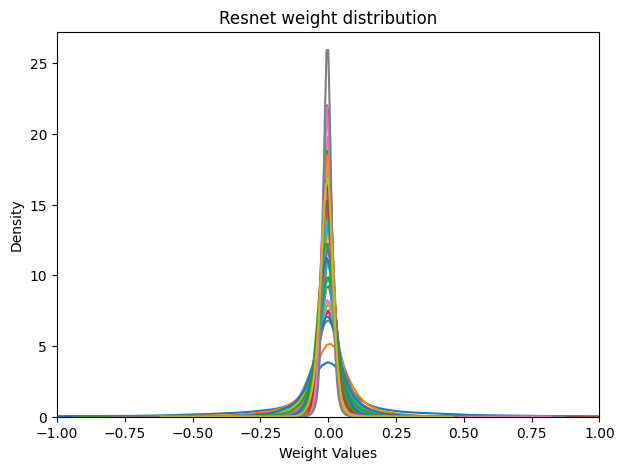

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
for name, parameters in model_resnet.named_parameters():
    if 'conv' in name:
        params = parameters.detach().cpu().numpy().flatten()
        sns.kdeplot(x=params, ax=ax)

ax.set_title('Resnet weight distribution')
ax.set_xlabel('Weight Values')
ax.set_xlim([-1, 1])
plt.tight_layout()

### 5. Comparing all predictions from the validation set

In [ ]:
# Change last layer to produce a single number
model.fc = nn.AdaptiveAvgPool1d(1)

# Load dataset
torch.backends.cudnn.allow_tf32 = True
preds_tf32, _ = utils.predict(model, dataloader_test, device)

torch.backends.cudnn.allow_tf32 = False
preds_fp32, _ = utils.predict(model, dataloader_test, device)

diff = preds_fp32 - preds_tf32
absolute_diff = np.abs(diff)
relative_diff = absolute_diff * 100 / preds_fp32

100%|██████████| 390/390 [02:59<00:00,  2.17it/s]


Text(0.5, 1.0, 'Relative difference (FP32 - TF32) * 100% / FP32')

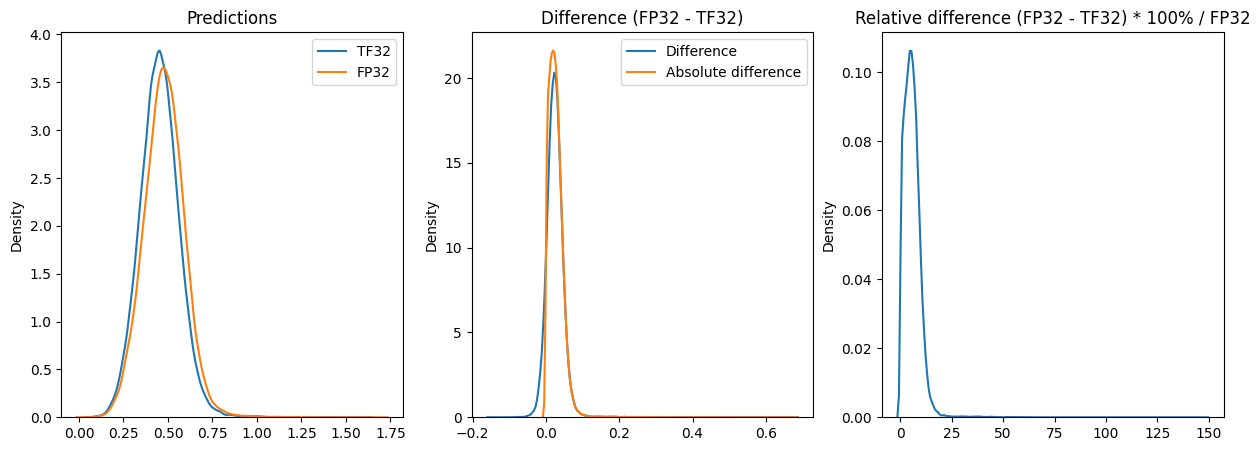

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

sns.kdeplot(x=preds_tf32, label='TF32', ax=ax[0])
sns.kdeplot(x=preds_fp32, label='FP32', ax=ax[0])
ax[0].legend()
ax[0].set_title('Predictions')

sns.kdeplot(x=diff, label='Difference', ax=ax[1])
sns.kdeplot(x=absolute_diff, label='Absolute difference', ax=ax[1])
ax[1].legend(loc='upper right')
ax[1].set_title('Difference (FP32 - TF32)')

sns.kdeplot(x=relative_diff, label='Relative difference (%)', ax=ax[2])
ax[2].set_title('Relative difference (FP32 - TF32) * 100% / FP32')
plt.tight_layout()

Text(0.5, 1.0, 'TF32 vs FP32')

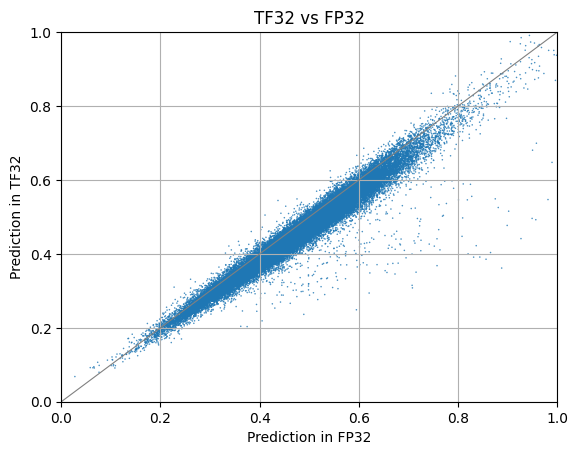

In [ ]:
fig, ax = plt.subplots(1, 1)
sns.scatterplot(x=preds_fp32, y=preds_tf32, alpha=0.8, s=5, marker='.', linewidths=None, edgecolors='None', ax=ax)
sns.lineplot(x=[0, 1], y=[0, 1], color='grey', linewidth=0.8, legend=False, ax=ax)
ax.set_xlabel('Prediction in FP32')
ax.set_ylabel('Prediction in TF32')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.grid()
ax.set_title('TF32 vs FP32')
plt.tight_layout()

### 6. Check intermediate outputs

In [68]:
# Load model again to get the last layer
model = bagnets.get_bagnet(backbone, weights=weights, num_classes=1000)
# checkpoint = torch.load(checkpoint_file, map_location=torch.device('cpu'))
# state_dict = checkpoint['state_dict'] if isinstance(checkpoint, dict) else checkpoint
# model.load_state_dict(state_dict)

for param in model.parameters():
    param.requires_grad = False

model.to(device)
model.eval();

In [64]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.layer1.register_forward_hook(get_activation('layer1'))

torch.backends.cudnn.allow_tf32 = True
output = model(img_batch)
intermediate_fp32 = activation['layer1'].cpu().numpy().flatten()

torch.backends.cudnn.allow_tf32 = False
output = model(img_batch)
intermediate_tf32 = activation['layer1'].cpu().numpy().flatten()

diff = intermediate_fp32 - intermediate_tf32
absolute_diff = np.abs(diff)
relative_diff = absolute_diff * 100 / intermediate_tf32

/tmp/ipykernel_1653948/2258387766.py:19: RuntimeWarning: divide by zero encountered in divide
  relative_diff = absolute_diff * 100 / intermediate_tf32
/tmp/ipykernel_1653948/2258387766.py:19: RuntimeWarning: invalid value encountered in divide
  relative_diff = absolute_diff * 100 / intermediate_tf32


Text(0.5, 1.0, 'Relative difference (FP32 - TF32) * 100% / FP32')

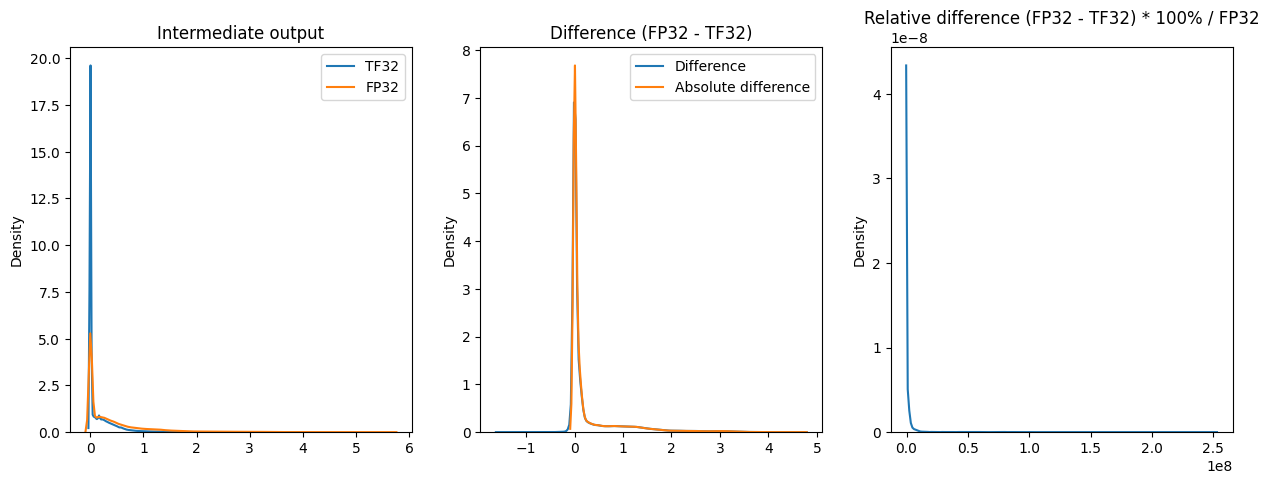

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

sns.kdeplot(x=intermediate_tf32, label='TF32', ax=ax[0])
sns.kdeplot(x=intermediate_fp32, label='FP32', ax=ax[0])
ax[0].legend()
ax[0].set_title('Intermediate output')

sns.kdeplot(x=diff, label='Difference', ax=ax[1])
sns.kdeplot(x=absolute_diff, label='Absolute difference', ax=ax[1])
ax[1].legend(loc='upper right')
ax[1].set_title('Difference (FP32 - TF32)')

sns.kdeplot(x=relative_diff, label='Relative difference (%)', ax=ax[2])
ax[2].set_title('Relative difference (FP32 - TF32) * 100% / FP32')
plt.tight_layout()

### 7. BagNet: removing dead convolutional layers
The predictions don't change when these layers are set to 0 which means they are having little to no influence in the output.

In [72]:
for name, parameters in model.named_parameters():
    if 'conv' in name:
        max_weight = parameters.flatten().abs().max()

        if max_weight <= 1e-4:
            parameters.zero_()

        max_weight = parameters.flatten().abs().max()
        # print(f'Maximum absolute value of the weights from layer {name} = {max_weight.item():.3e}')

In [73]:
torch.backends.cudnn.allow_tf32 = True
prediction_tf32 = model(img_batch)[0, img_label]
print(f'Prediction with tf32 = {prediction_tf32.item():.4f}')

torch.backends.cudnn.allow_tf32 = False
prediction_fp32 = model(img_batch)[0, img_label]
print(f'Prediction with fp32 = {prediction_fp32.item():.4f}')

absolute_diff = (prediction_fp32 - prediction_tf32).abs()
print(f'Absolute difference = {absolute_diff.item():.3e}')

relative_diff = (prediction_fp32 - prediction_tf32).abs() * 100 / prediction_tf32
print(f'Relative difference = {relative_diff.item():.2f}%')

Prediction with tf32 = 17.7340
Prediction with fp32 = 16.3335
Absolute difference = 1.400e+00
Relative difference = 7.90%


### 8. BagNet: removing dead convolutional layers + batch normalization bias

In [74]:
for name, parameters in model.named_parameters():
    if 'bn' and 'bias' in name:
        parameters.zero_()
        max_weight = parameters.flatten().abs().max()

        # print(f'Maximum absolute value of the weights from layer {name} = {max_weight.item():.3e}')

In [76]:
torch.backends.cudnn.allow_tf32 = True
prediction_tf32 = model(img_batch)[0, img_label]
print(f'Prediction with tf32 = {prediction_tf32.item():.4f}')

torch.backends.cudnn.allow_tf32 = False
prediction_fp32 = model(img_batch)[0, img_label]
print(f'Prediction with fp32 = {prediction_fp32.item():.4f}')

absolute_diff = (prediction_fp32 - prediction_tf32).abs()
print(f'Absolute difference = {absolute_diff.item():.3e}')

relative_diff = (prediction_fp32 - prediction_tf32).abs() * 100 / prediction_tf32
print(f'Relative difference = {relative_diff.item():.2f}%')

Prediction with tf32 = -2266.7893
Prediction with fp32 = -2267.8010
Absolute difference = 1.012e+00
Relative difference = -0.04%


### 9. Check heatmaps

In [78]:
# Load model again to get original weights
model = bagnets.get_bagnet(backbone, weights=weights, num_classes=1000)
# checkpoint = torch.load(checkpoint_file, map_location=torch.device('cpu'))
# state_dict = checkpoint['state_dict'] if isinstance(checkpoint, dict) else checkpoint
# model.load_state_dict(state_dict)

for param in model.parameters():
    param.requires_grad = False

model.to(device)
model.eval();

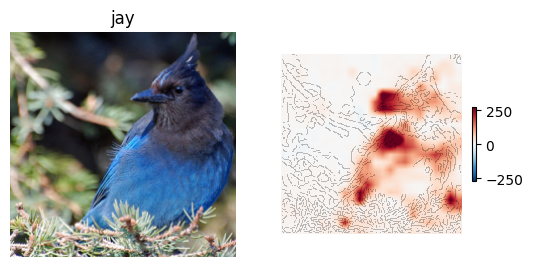

In [ ]:
img_idx = np.random.randint(0, len(dataset_test))

img_orig = dataset_orig[img_idx][0]
img_batch = dataset_test[img_idx][0].unsqueeze(0).to(device)
img_label = dataset_test[img_idx][1]

model.avg_pool = False

fig, ax = plt.subplots(1, 2)
hm = model(img_batch).squeeze().cpu().detach().numpy()
ax[0].imshow(transforms.ToPILImage()(img_orig))
ax[0].set_axis_off()
ax[0].set_title(dataset_test.classes[img_label][0])

bagnets.plot_heatmap(hm[:, :, img_label], img_orig, fig, ax[1], percentile=99)
plt.tight_layout()